### Importing packages and dataset

In [1]:
import sys
assert sys.version_info >= (3, 5)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import stack
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import tensorflow as tf
from tensorflow import keras
from google.colab import drive
import seaborn as sns; sns.set()

In [2]:
drive.mount('/content/gdrive')
df_train = pd.read_csv("gdrive/My Drive/fashion-mnist_train.csv")
df_test = pd.read_csv("gdrive/My Drive/fashion-mnist_test.csv")

Mounted at /content/gdrive


In [3]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
y_train = df_train[["label"]]
df_train = df_train.to_numpy()
X_train = df_train[:,1:].reshape(df_train.shape[0],28,28).astype( 'float32' )
X_train = X_train/255.0

In [5]:
X_train.shape

(60000, 28, 28)

In [6]:
y_train.shape

(60000, 1)

In [7]:
df_test.shape

(10000, 785)

In [8]:
df_valid, df_test = df_test[:5000], df_test[5000:] 

In [9]:
y_test = df_test[["label"]]
df_test = df_test.to_numpy()
X_test = df_test[:,1:].reshape(df_test.shape[0],28,28).astype( 'float32' )
X_test = X_test/255.0

In [10]:
X_test.shape

(5000, 28, 28)

In [11]:
y_valid = df_valid[["label"]]
df_valid = df_valid.to_numpy()
X_valid = df_valid[:,1:].reshape(df_valid.shape[0],28,28).astype( 'float32' )
X_test = X_test/255.0
y_valid.shape

(5000, 1)

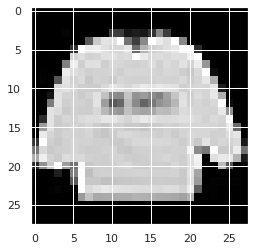

In [12]:
image = X_train[0]
fig = plt.figure
plt.imshow(image, cmap = 'gray')
plt.show()

### Defining a baseline CNN model

In [13]:
n_train = 60000
n_valid = 784
# number and size of hidden layers
hiddensizes = [60, 30, 25] 
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.Adam
# learning rate
learningrate = 0.001
# size of batch and number of epochs
batch_size = 50
n_epochs = 20
def model_cnn(hiddensizes, actfn, optimizer, learningrate=0):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", 
                                  input_shape=[28, 28, 1]))    # input layer goes into this 2D convolution
    model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn)) 
        model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
    model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, strides=1, padding="same", activation=actfn)) 
    model.add(keras.layers.Flatten())                          # unravel into a 1D vector
    model.add(keras.layers.Dense(10, activation = "softmax"))  # 10 classes for this dataset
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])   
    return model

In [ ]:
# early stopping callback to help set a limit of runs
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) 

In [165]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    if further_callbacks != []:
        callbacks = further_callbacks
    else:
        callbacks = [early_stopping_cb]
    model = model_cnn(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:], y_train[:n_train], epochs=n_epochs, callbacks = callbacks,
                        validation_data=(X_valid[:n_valid,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

In [ ]:
# Function that tests the model above
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/20
1875/1875 [==============================] - 125s 66ms/step - loss: 0.4445 - accuracy: 0.8417 - val_loss: 33.6246 - val_accuracy: 0.8801
Epoch 2/20
1875/1875 [==============================] - 122s 65ms/step - loss: 0.2980 - accuracy: 0.8929 - val_loss: 24.0453 - val_accuracy: 0.9018
Epoch 3/20
1875/1875 [==============================] - 123s 66ms/step - loss: 0.2577 - accuracy: 0.9068 - val_loss: 32.2996 - val_accuracy: 0.8673
Epoch 4/20
1875/1875 [==============================] - 124s 66ms/step - loss: 0.2338 - accuracy: 0.9153 - val_loss: 25.6315 - val_accuracy: 0.8916
Epoch 5/20
1875/1875 [==============================] - 122s 65ms/step - loss: 0.2133 - accuracy: 0.9223 - val_loss: 23.6020 - val_accuracy: 0.8814
Epoch 6/20
1875/1875 [==============================] - 122s 65ms/step - loss: 0.1982 - accuracy: 0.9276 - val_loss: 37.0744 - val_accuracy: 0.8712
Epoch 7/20
1875/1875 [==============================] - 120s 64ms/step - loss: 0.1845 - accuracy: 0.9334 - val_l

### CNN: Model comparison

###### I decided to increase the hidden sizes. First I tested a smaller learning rate. 

In [ ]:
# Model 1 with LR 0.0001
n_train = 60000
n_valid = 784
hiddensizes = [100, 30, 20] 
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.Adam
# learning rate
learningrate = 0.0001
# size of batch and number of epochs
batch_size = 50
n_epochs = 10

def model_cnn(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", input_shape=[28, 28, 1]))
    model.add(keras.layers.MaxPooling2D(pool_size=2))

    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn)) 
        model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
    model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, strides=1, padding="same", activation=actfn)) 
    model.add(keras.layers.Flatten())                          # unravel into a 1D vector
    model.add(keras.layers.Dense(10, activation = "softmax"))  # 10 classes for this dataset
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])   
    return model

In [ ]:
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/10
1875/1875 [==============================] - 172s 92ms/step - loss: 0.7456 - accuracy: 0.7320 - val_loss: 65.2549 - val_accuracy: 0.7717
Epoch 2/10
1875/1875 [==============================] - 171s 91ms/step - loss: 0.4815 - accuracy: 0.8278 - val_loss: 49.7254 - val_accuracy: 0.8214
Epoch 3/10
1875/1875 [==============================] - 170s 91ms/step - loss: 0.4259 - accuracy: 0.8490 - val_loss: 54.3202 - val_accuracy: 0.8304
Epoch 4/10
1875/1875 [==============================] - 170s 91ms/step - loss: 0.3951 - accuracy: 0.8591 - val_loss: 56.3273 - val_accuracy: 0.8176
Epoch 5/10
1875/1875 [==============================] - 170s 91ms/step - loss: 0.3718 - accuracy: 0.8681 - val_loss: 61.1163 - val_accuracy: 0.8240
Epoch 6/10
1875/1875 [==============================] - 171s 91ms/step - loss: 0.3534 - accuracy: 0.8745 - val_loss: 50.0909 - val_accuracy: 0.8355
Epoch 7/10
1875/1875 [==============================] - 170s 91ms/step - loss: 0.3379 - accuracy: 0.8808 - val_l

###### Accuracy appeared to improve using the same LR as the baseline.

In [ ]:
# Model 2 
# Baseline with LR 0.001

n_train = 60000
n_valid = 784
hiddensizes = [100, 30, 20] 
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.Adam
# learning rate
learningrate = 0.001
# size of batch and number of epochs
batch_size = 50
n_epochs = 10

def model_cnn(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", input_shape=[28, 28, 1]))
    model.add(keras.layers.MaxPooling2D(pool_size=2))

    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn)) 
        model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
    model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, strides=1, padding="same", activation=actfn))  
    model.add(keras.layers.Flatten())                          # unravel into a 1D vector
    model.add(keras.layers.Dense(10, activation = "softmax"))  # 10 classes for this dataset
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])   
    return model

In [ ]:
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/10
1875/1875 [==============================] - 171s 91ms/step - loss: 0.4540 - accuracy: 0.8348 - val_loss: 41.5182 - val_accuracy: 0.8469
Epoch 2/10
1875/1875 [==============================] - 173s 92ms/step - loss: 0.3061 - accuracy: 0.8912 - val_loss: 32.7186 - val_accuracy: 0.8737
Epoch 3/10
1875/1875 [==============================] - 170s 91ms/step - loss: 0.2641 - accuracy: 0.9047 - val_loss: 31.1569 - val_accuracy: 0.8967
Epoch 4/10
1875/1875 [==============================] - 177s 94ms/step - loss: 0.2380 - accuracy: 0.9130 - val_loss: 30.3425 - val_accuracy: 0.8916
Epoch 5/10
1875/1875 [==============================] - 175s 93ms/step - loss: 0.2176 - accuracy: 0.9208 - val_loss: 30.3917 - val_accuracy: 0.8916
Epoch 6/10
1875/1875 [==============================] - 173s 92ms/step - loss: 0.2024 - accuracy: 0.9266 - val_loss: 29.2807 - val_accuracy: 0.8980
Epoch 7/10
1875/1875 [==============================] - 173s 92ms/step - loss: 0.1890 - accuracy: 0.9319 - val_l

In [164]:
# Model 3 
# strides = 2

n_train = 60000
n_valid = 784
hiddensizes = [100, 30, 20] 
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.Adam
# learning rate
learningrate = 0.001
# size of batch and number of epochs
batch_size = 50
n_epochs = 10

def model_cnn(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=2, activation=actfn, padding="same", input_shape=[28, 28, 1]))
    model.add(keras.layers.MaxPooling2D(pool_size=2))

    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=2, padding="same", activation=actfn))
        model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
    model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, strides=2, padding="same", activation=actfn))
    model.add(keras.layers.Flatten())                          # unravel into a 1D vector
    model.add(keras.layers.Dense(10, activation = "softmax"))  # 10 classes for this dataset
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])   
    return model

In [166]:
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.6206 - accuracy: 0.7778 - val_loss: 46.6157 - val_accuracy: 0.8189
Epoch 2/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.3986 - accuracy: 0.8576 - val_loss: 44.9667 - val_accuracy: 0.8202
Epoch 3/10
1875/1875 [==============================] - 55s 29ms/step - loss: 0.3488 - accuracy: 0.8738 - val_loss: 54.9032 - val_accuracy: 0.7985
Epoch 4/10
1875/1875 [==============================] - 39s 21ms/step - loss: 0.3192 - accuracy: 0.8854 - val_loss: 63.0643 - val_accuracy: 0.7768
Epoch 5/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.3000 - accuracy: 0.8917 - val_loss: 52.3403 - val_accuracy: 0.8202
Epoch 6/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.2860 - accuracy: 0.8981 - val_loss: 80.7530 - val_accuracy: 0.7742
Epoch 7/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.2732 - accuracy: 0.9019 - val_loss: 86

In [ ]:
# Model 4 
# Extra Max Pooling layer

n_train = 60000
n_valid = 784
hiddensizes = [100, 30, 20] 
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.Adam
# learning rate
learningrate = 0.001
# size of batch and number of epochs
batch_size = 50
n_epochs = 10

def model_cnn(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", input_shape=[28, 28, 1]))
    model.add(keras.layers.MaxPooling2D(pool_size=2))
    model.add(keras.layers.MaxPooling2D(pool_size=2))

    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn))
        model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
    model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=1, strides=3, padding="same", activation=actfn))
    model.add(keras.layers.Flatten())                          # unravel into a 1D vector
    model.add(keras.layers.Dense(10, activation = "softmax"))  # 10 classes for this dataset
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])   
    return model

In [ ]:
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/10
1875/1875 [==============================] - 111s 59ms/step - loss: 0.9963 - accuracy: 0.6185 - val_loss: 81.4844 - val_accuracy: 0.6339
Epoch 2/10
1875/1875 [==============================] - 111s 59ms/step - loss: 0.7678 - accuracy: 0.7110 - val_loss: 83.1422 - val_accuracy: 0.6671
Epoch 3/10
1875/1875 [==============================] - 111s 59ms/step - loss: 0.7190 - accuracy: 0.7295 - val_loss: 76.9605 - val_accuracy: 0.6543
Epoch 4/10
1875/1875 [==============================] - 111s 59ms/step - loss: 0.6886 - accuracy: 0.7405 - val_loss: 79.1466 - val_accuracy: 0.6454
Epoch 5/10
1875/1875 [==============================] - 111s 59ms/step - loss: 0.6668 - accuracy: 0.7468 - val_loss: 90.0846 - val_accuracy: 0.6429
Epoch 6/10
1875/1875 [==============================] - 108s 58ms/step - loss: 0.6480 - accuracy: 0.7540 - val_loss: 86.0161 - val_accuracy: 0.6212
Epoch 7/10
1875/1875 [==============================] - 107s 57ms/step - loss: 0.6340 - accuracy: 0.7590 - val_l

In [ ]:
# Model 5 
# two convolutional layers

n_train = 60000
n_valid = 784
hiddensizes = [100, 30, 20] 
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.Adam
# learning rate
learningrate = 0.001
# size of batch and number of epochs
batch_size = 50
n_epochs = 10

def model_cnn(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", input_shape=[28, 28, 1]))
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", input_shape=[28, 28, 1]))
    model.add(keras.layers.MaxPooling2D(pool_size=2))

    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn))  
        model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
    model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, strides=1, padding="same", activation=actfn))  
    model.add(keras.layers.Flatten())                          # unravel into a 1D vector
    model.add(keras.layers.Dense(10, activation = "softmax"))  # 10 classes for this dataset
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])   
    return model

In [ ]:
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/10
1875/1875 [==============================] - 806s 430ms/step - loss: 0.4231 - accuracy: 0.8475 - val_loss: 23.6156 - val_accuracy: 0.8801
Epoch 2/10
1875/1875 [==============================] - 803s 428ms/step - loss: 0.2752 - accuracy: 0.9017 - val_loss: 21.6873 - val_accuracy: 0.8673
Epoch 3/10
1875/1875 [==============================] - 807s 430ms/step - loss: 0.2362 - accuracy: 0.9148 - val_loss: 33.5941 - val_accuracy: 0.8304
Epoch 4/10
1875/1875 [==============================] - 809s 431ms/step - loss: 0.2098 - accuracy: 0.9222 - val_loss: 22.9450 - val_accuracy: 0.8635
Epoch 5/10
1875/1875 [==============================] - 811s 432ms/step - loss: 0.1873 - accuracy: 0.9308 - val_loss: 22.8133 - val_accuracy: 0.8571
Epoch 6/10
1875/1875 [==============================] - 810s 432ms/step - loss: 0.1689 - accuracy: 0.9388 - val_loss: 25.3612 - val_accuracy: 0.8686
Model: "sequential_5"
_________________________________________________________________
 Layer (type)     

In [ ]:
# Model 6 
# relu activation function in dense layer
n_train = 60000
n_valid = 784
hiddensizes = [100, 30, 20] 
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.Adam
# learning rate
learningrate = 0.001
# size of batch and number of epochs
batch_size = 50
n_epochs = 10

def model_cnn(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", input_shape=[28, 28, 1]))
    model.add(keras.layers.MaxPooling2D(pool_size=2))

    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn)) 
        model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
    model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, strides=1, padding="same", activation=actfn)) 
    model.add(keras.layers.Flatten())                          # unravel into a 1D vector
    model.add(keras.layers.Dense(10, activation = "relu"))  # 10 classes for this dataset
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])   
    return model

In [ ]:
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/10
1875/1875 [==============================] - 177s 94ms/step - loss: 2.3512 - accuracy: 0.1027 - val_loss: 2.3026 - val_accuracy: 0.0957
Epoch 2/10
1875/1875 [==============================] - 176s 94ms/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.0957
Epoch 3/10
1875/1875 [==============================] - 172s 92ms/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.0957
Epoch 4/10
1875/1875 [==============================] - 171s 91ms/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.0957
Epoch 5/10
1875/1875 [==============================] - 169s 90ms/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.0957
Epoch 6/10
1875/1875 [==============================] - 166s 88ms/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.0957
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                O

In [ ]:
# Model 7 
# two convolutional layers and two convolutional hidden layers
n_train = 60000
n_valid = 784
hiddensizes = [100, 30, 20] 
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.Adam
learningrate = 0.001
# size of batch and number of epochs
batch_size = 50
n_epochs = 10

def model_cnn(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", input_shape=[28, 28, 1]))
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", input_shape=[28, 28, 1]))
    model.add(keras.layers.MaxPooling2D(pool_size=2))

    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn)) 
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn))
        model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
        model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, strides=1, padding="same", activation=actfn))
        model.add(keras.layers.Flatten())                          # unravel into a 1D vector
        model.add(keras.layers.Dense(10, activation = "softmax"))  # 10 classes for this dataset
        model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])   
    return model

In [ ]:
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/10
1875/1875 [==============================] - 827s 441ms/step - loss: 0.4298 - accuracy: 0.8457 - val_loss: 23.1169 - val_accuracy: 0.8878
Epoch 2/10
1875/1875 [==============================] - 830s 443ms/step - loss: 0.2741 - accuracy: 0.9011 - val_loss: 19.6854 - val_accuracy: 0.8916
Epoch 3/10
1875/1875 [==============================] - 834s 445ms/step - loss: 0.2348 - accuracy: 0.9150 - val_loss: 15.0602 - val_accuracy: 0.8814
Epoch 4/10
1875/1875 [==============================] - 852s 454ms/step - loss: 0.2102 - accuracy: 0.9238 - val_loss: 22.8583 - val_accuracy: 0.8801
Epoch 5/10
1875/1875 [==============================] - 834s 445ms/step - loss: 0.1918 - accuracy: 0.9289 - val_loss: 25.2183 - val_accuracy: 0.8406
Epoch 6/10
1875/1875 [==============================] - 832s 444ms/step - loss: 0.1737 - accuracy: 0.9369 - val_loss: 27.8370 - val_accuracy: 0.8559
Epoch 7/10
1875/1875 [==============================] - 827s 441ms/step - loss: 0.1615 - accuracy: 0.9412 

### A competing approach: Dense Neural Networks

In [ ]:
# DNN Model 1
# Baseline DNN with one layer and softmax

n_train = 60000
n_valid = 784
# number and size of hidden layers
hiddensizes = [100, 30, 20]  # testing out one extra layer
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.Adam
learningrate = 0.001
# size of batch and number of epochs
batch_size = 50
n_epochs = 20

# and the function
def model_dense(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28, 28, 1]))    
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = actfn))
    model.add(keras.layers.Dense(25, activation = "softmax")) 
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])
    return model

In [18]:
# early stopping callback to help set a limit of runs
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) 

In [ ]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    if further_callbacks != []:
        callbacks = further_callbacks
    else:
        callbacks = [early_stopping_cb]
    model = model_dense(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:], y_train[:n_train], epochs=n_epochs, callbacks = callbacks,
                        validation_data=(X_valid[:n_valid,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

In [ ]:
# Function that tests the model above
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5547 - accuracy: 0.8073 - val_loss: 73.0373 - val_accuracy: 0.8227
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3905 - accuracy: 0.8586 - val_loss: 49.5263 - val_accuracy: 0.8571
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3572 - accuracy: 0.8695 - val_loss: 50.9310 - val_accuracy: 0.8520
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3351 - accuracy: 0.8783 - val_loss: 58.0798 - val_accuracy: 0.8495
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3176 - accuracy: 0.8828 - val_loss: 54.1371 - val_accuracy: 0.8457
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3035 - accuracy: 0.8883 - val_loss: 41.6137 - val_accuracy: 0.8686
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2919 - accuracy: 0.8916 - val_loss: 55.6136 - val_ac

In [ ]:
# DNN Model 2
# two dense hidden layers in preactivation

n_train = 60000
n_valid = 784
# number and size of hidden layers
hiddensizes = [100, 30, 20]  # testing out one extra layer
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.Adam
learningrate = 0.001
# size of batch and number of epochs
batch_size = 50
n_epochs = 20

# and the function
def model_dense(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28, 28, 1]))   
    model.add(keras.layers.Flatten(input_shape = [28, 28, 1]))    
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = actfn))
    model.add(keras.layers.Dense(25, activation = "softmax")) 
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])
    return model

In [ ]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    if further_callbacks != []:
        callbacks = further_callbacks
    else:
        callbacks = [early_stopping_cb]
    model = model_dense(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:], y_train[:n_train], epochs=n_epochs, callbacks = callbacks,
                        validation_data=(X_valid[:n_valid,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

In [ ]:
# Test the above model
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/20
1875/1875 [==============================] - 7s 3ms/step - loss: 0.5937 - accuracy: 0.7982 - val_loss: 54.0141 - val_accuracy: 0.8457
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3999 - accuracy: 0.8574 - val_loss: 45.4137 - val_accuracy: 0.8686
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3592 - accuracy: 0.8700 - val_loss: 51.4301 - val_accuracy: 0.8648
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3340 - accuracy: 0.8785 - val_loss: 41.4029 - val_accuracy: 0.8622
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3138 - accuracy: 0.8845 - val_loss: 51.2458 - val_accuracy: 0.8622
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3014 - accuracy: 0.8882 - val_loss: 46.7191 - val_accuracy: 0.8737
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2894 - accuracy: 0.8930 - val_loss: 51.2893 - val_ac

In [ ]:
# DNN Model 3
# two dense layers in preactivation


n_train = 60000
n_valid = 784
# number and size of hidden layers
hiddensizes = [100, 30, 20]  # testing out one extra layer
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.Adam
learningrate = 0.001
# size of batch and number of epochs
batch_size = 50
n_epochs = 20

# and the function
def model_dense(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28, 28, 1]))
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = actfn))
        model.add(keras.layers.Dense(n, activation = actfn))
    model.add(keras.layers.Dense(25, activation = "softmax"))  
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])
    return model

In [ ]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    if further_callbacks != []:
        callbacks = further_callbacks
    else:
        callbacks = [early_stopping_cb]
    model = model_dense(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:], y_train[:n_train], epochs=n_epochs, callbacks = callbacks,
                        validation_data=(X_valid[:n_valid,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

In [ ]:
# Function that tests the model above
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6202 - accuracy: 0.7844 - val_loss: 60.0574 - val_accuracy: 0.8380
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4054 - accuracy: 0.8554 - val_loss: 60.0390 - val_accuracy: 0.8444
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3625 - accuracy: 0.8686 - val_loss: 46.6277 - val_accuracy: 0.8559
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3381 - accuracy: 0.8771 - val_loss: 51.1106 - val_accuracy: 0.8393
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3236 - accuracy: 0.8820 - val_loss: 53.8793 - val_accuracy: 0.8559
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3084 - accuracy: 0.8862 - val_loss: 45.6585 - val_accuracy: 0.8559
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2952 - accuracy: 0.8919 - val_loss: 45.9286 - val_ac

In [ ]:
# DNN Model 4
# two dense layers in preactivation
# two dense hidden layers in forward propogation

n_train = 60000
n_valid = 784
# number and size of hidden layers
hiddensizes = [100, 30, 20]  # testing out one extra layer
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.Adam
learningrate = 0.001
# size of batch and number of epochs
batch_size = 50
n_epochs = 20

# and the function
def model_dense(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28, 28, 1]))  
    model.add(keras.layers.Flatten(input_shape = [28, 28, 1]))    
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = actfn))
        model.add(keras.layers.Dense(n, activation = actfn))
    model.add(keras.layers.Dense(25, activation = "softmax"))  
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])
    return model

In [ ]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    if further_callbacks != []:
        callbacks = further_callbacks
    else:
        callbacks = [early_stopping_cb]
    model = model_dense(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:], y_train[:n_train], epochs=n_epochs, callbacks = callbacks,
                        validation_data=(X_valid[:n_valid,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

In [ ]:
# Function that tests the model above
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6149 - accuracy: 0.7856 - val_loss: 45.0254 - val_accuracy: 0.8508
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4047 - accuracy: 0.8554 - val_loss: 49.2977 - val_accuracy: 0.8482
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3651 - accuracy: 0.8673 - val_loss: 52.0758 - val_accuracy: 0.8469
Epoch 4/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3392 - accuracy: 0.8778 - val_loss: 40.4182 - val_accuracy: 0.8597
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3202 - accuracy: 0.8845 - val_loss: 52.3122 - val_accuracy: 0.8418
Epoch 6/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3069 - accuracy: 0.8879 - val_loss: 46.2915 - val_accuracy: 0.8469
Epoch 7/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2924 - accuracy: 0.8925 - val_loss: 35.5741 - val_ac

In [ ]:
# DNN Model 5
# relu activation in foward propogation

n_train = 60000
n_valid = 784
# number and size of hidden layers
hiddensizes = [100, 30, 20]  # testing out one extra layer
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.Adam
# best learning rate as per the tests below
learningrate = 0.001 # best learning rate as found below
# size of batch and number of epochs
batch_size = 50
n_epochs = 20

# and the function
def model_dense(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28, 28, 1]))  
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = actfn))
    model.add(keras.layers.Dense(10, activation = "relu"))  
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])
    return model

In [ ]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    if further_callbacks != []:
        callbacks = further_callbacks
    else:
        callbacks = [early_stopping_cb]
    model = model_dense(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:], y_train[:n_train], epochs=n_epochs, callbacks = callbacks,
                        validation_data=(X_valid[:n_valid,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

In [ ]:
# Test the model above
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/20
1875/1875 [==============================] - 7s 3ms/step - loss: 2.4937 - accuracy: 0.1450 - val_loss: 2.3026 - val_accuracy: 0.0957
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 2.3026 - accuracy: 0.1001 - val_loss: 2.3026 - val_accuracy: 0.0957
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 2.3064 - accuracy: 0.1001 - val_loss: 2.3026 - val_accuracy: 0.0957
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.0957
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.0957
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.0957
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape      

In [ ]:
# DNN Model 6
# Original DNN with increased hidden layer sizes

n_train = 60000
n_valid = 784
# number and size of hidden layers
hiddensizes = [1000, 300, 200] 
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.Adam
learningrate = 0.001 
# size of batch and number of epochs
batch_size = 50
n_epochs = 20

# and the function
def model_dense(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28, 28, 1])) 
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = actfn))
    model.add(keras.layers.Dense(25, activation = "softmax")) 
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])
    return model

In [ ]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    if further_callbacks != []:
        callbacks = further_callbacks
    else:
        callbacks = [early_stopping_cb]
    model = model_dense(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:], y_train[:n_train], epochs=n_epochs, callbacks = callbacks,
                        validation_data=(X_valid[:n_valid,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

In [ ]:
# Function that tests the model above
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/20
1875/1875 [==============================] - 29s 15ms/step - loss: 0.4918 - accuracy: 0.8225 - val_loss: 42.8082 - val_accuracy: 0.8597
Epoch 2/20
1875/1875 [==============================] - 28s 15ms/step - loss: 0.3690 - accuracy: 0.8647 - val_loss: 38.1493 - val_accuracy: 0.8610
Epoch 3/20
1875/1875 [==============================] - 28s 15ms/step - loss: 0.3312 - accuracy: 0.8773 - val_loss: 38.1442 - val_accuracy: 0.8827
Epoch 4/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.3041 - accuracy: 0.8874 - val_loss: 42.1049 - val_accuracy: 0.8801
Epoch 5/20
1875/1875 [==============================] - 31s 16ms/step - loss: 0.2868 - accuracy: 0.8934 - val_loss: 36.4761 - val_accuracy: 0.8827
Epoch 6/20
1875/1875 [==============================] - 29s 15ms/step - loss: 0.2704 - accuracy: 0.8997 - val_loss: 46.6699 - val_accuracy: 0.8661
Epoch 7/20
1875/1875 [==============================] - 29s 15ms/step - loss: 0.2599 - accuracy: 0.9028 - val_loss: 49

In [ ]:
# DNN Model 7
# Baseline with increased batch size
# increased hidden layer size

n_train = 60000
n_valid = 784
# number and size of hidden layers
hiddensizes = [1000, 300, 200]  # testing out one extra layer
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.Adam
# best learning rate as per the tests below
learningrate = 0.001 # best learning rate as found below
# size of batch and number of epochs
batch_size = 100
n_epochs = 20

# and the function
def model_dense(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28, 28, 1]))   
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = actfn))
    model.add(keras.layers.Dense(25, activation = "softmax"))   
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])
    return model

In [ ]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    if further_callbacks != []:
        callbacks = further_callbacks
    else:
        callbacks = [early_stopping_cb]
    model = model_dense(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:], y_train[:n_train], epochs=n_epochs, callbacks = callbacks,
                        validation_data=(X_valid[:n_valid,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

In [ ]:
# Function that tests the model above
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/20
1875/1875 [==============================] - 28s 15ms/step - loss: 0.4911 - accuracy: 0.8216 - val_loss: 51.6129 - val_accuracy: 0.8393
Epoch 2/20
1875/1875 [==============================] - 27s 15ms/step - loss: 0.3716 - accuracy: 0.8650 - val_loss: 41.0632 - val_accuracy: 0.8457
Epoch 3/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.3304 - accuracy: 0.8784 - val_loss: 37.8704 - val_accuracy: 0.8776
Epoch 4/20
1875/1875 [==============================] - 28s 15ms/step - loss: 0.3081 - accuracy: 0.8850 - val_loss: 49.7821 - val_accuracy: 0.8520
Epoch 5/20
1875/1875 [==============================] - 28s 15ms/step - loss: 0.2880 - accuracy: 0.8923 - val_loss: 43.3660 - val_accuracy: 0.8610
Epoch 6/20
1875/1875 [==============================] - 28s 15ms/step - loss: 0.2750 - accuracy: 0.8959 - val_loss: 48.2491 - val_accuracy: 0.8635
Epoch 7/20
1875/1875 [==============================] - 26s 14ms/step - loss: 0.2617 - accuracy: 0.9017 - val_loss: 48

In [14]:
# DNN Model 8
# baseline with increased hidden layer size
# more epochs

n_train = 60000
n_valid = 784
# number and size of hidden layers
hiddensizes = [1000, 300, 200]  # testing out one extra layer
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.Adam
# best learning rate as per the tests below
learningrate = 0.001 # best learning rate as found below
# size of batch and number of epochs
batch_size = 50
n_epochs = 100

# and the function
def model_dense(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28, 28, 1]))   
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = actfn))
    model.add(keras.layers.Dense(25, activation = "softmax"))  
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])
    return model

In [15]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    if further_callbacks != []:
        callbacks = further_callbacks
    else:
        callbacks = [early_stopping_cb]
    model = model_dense(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:], y_train[:n_train], epochs=n_epochs, callbacks = callbacks,
                        validation_data=(X_valid[:n_valid,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

In [19]:
# Function that tests the model above
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/100
1875/1875 [==============================] - 27s 14ms/step - loss: 0.4932 - accuracy: 0.8217 - val_loss: 46.9897 - val_accuracy: 0.8648
Epoch 2/100
1875/1875 [==============================] - 25s 14ms/step - loss: 0.3703 - accuracy: 0.8655 - val_loss: 53.0990 - val_accuracy: 0.8278
Epoch 3/100
1875/1875 [==============================] - 27s 15ms/step - loss: 0.3326 - accuracy: 0.8783 - val_loss: 47.4716 - val_accuracy: 0.8597
Epoch 4/100
1875/1875 [==============================] - 27s 14ms/step - loss: 0.3061 - accuracy: 0.8878 - val_loss: 43.3303 - val_accuracy: 0.8724
Epoch 5/100
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2897 - accuracy: 0.8918 - val_loss: 46.2517 - val_accuracy: 0.8610
Epoch 6/100
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2760 - accuracy: 0.8960 - val_loss: 34.9231 - val_accuracy: 0.8916
Epoch 7/100
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2607 - accuracy: 0.9022 - val_l

In [17]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    if further_callbacks != []:
        callbacks = further_callbacks
    else:
        callbacks = [early_stopping_cb]
    model = model_dense(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:], y_train[:n_train], epochs=n_epochs, callbacks = callbacks,
                        validation_data=(X_valid[:n_valid,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

### Final model comparison and run on test set

###### Starting with CNN:

In [167]:
# Model 2 using new hidden sizes
# Baseline with LR 0.0001

n_train = 60000
n_valid = 784
hiddensizes = [32, 64, 96] 
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.Adam
# learning rate
learningrate = 0.0001
# size of batch and number of epochs
batch_size = 50
n_epochs = 20

def model_cnn(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", input_shape=[28, 28, 1]))
    model.add(keras.layers.MaxPooling2D(pool_size=2))

    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn)) 
        model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
        model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, strides=1, padding="same", activation=actfn))  
        model.add(keras.layers.Flatten())                          # unravel into a 1D vector
        model.add(keras.layers.Dense(10, activation = "softmax"))  # 10 classes for this dataset
        model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])   
    return model

In [168]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    if further_callbacks != []:
        callbacks = further_callbacks
    else:
        callbacks = [early_stopping_cb]
    model = model_cnn(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:], y_train[:n_train], epochs=n_epochs, callbacks = callbacks,
                        validation_data=(X_valid[:n_valid,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

In [169]:
# Function that tests the model above
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/20
1875/1875 [==============================] - 112s 59ms/step - loss: 0.6467 - accuracy: 0.7716 - val_loss: 47.3778 - val_accuracy: 0.8304
Epoch 2/20
1875/1875 [==============================] - 111s 59ms/step - loss: 0.4231 - accuracy: 0.8494 - val_loss: 41.8094 - val_accuracy: 0.8444
Epoch 3/20
1875/1875 [==============================] - 113s 60ms/step - loss: 0.3732 - accuracy: 0.8681 - val_loss: 37.9819 - val_accuracy: 0.8724
Epoch 4/20
1875/1875 [==============================] - 131s 70ms/step - loss: 0.3440 - accuracy: 0.8784 - val_loss: 38.6070 - val_accuracy: 0.8712
Epoch 5/20
1875/1875 [==============================] - 117s 62ms/step - loss: 0.3225 - accuracy: 0.8857 - val_loss: 34.2565 - val_accuracy: 0.8801
Epoch 6/20
1875/1875 [==============================] - 111s 59ms/step - loss: 0.3046 - accuracy: 0.8912 - val_loss: 39.4642 - val_accuracy: 0.8635
Epoch 7/20
1875/1875 [==============================] - 111s 59ms/step - loss: 0.2895 - accuracy: 0.8967 - val_l

In [170]:
def plot_history(history):
    # Plot the results (shifting validation curves appropriately)
    plt.figure(figsize=(8,5))
    n = len(history.history['accuracy'])
    plt.plot(np.arange(0,n),history.history['accuracy'], color='orange')
    plt.plot(np.arange(0,n),history.history['loss'],'b')
    plt.plot(np.arange(0,n)+0.5,history.history['val_accuracy'],'r')  # offset both validation curves
    plt.plot(np.arange(0,n)+0.5,history.history['val_loss'],'g')
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] 
    plt.show() 

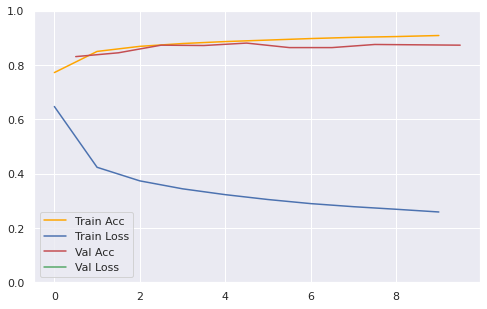

In [171]:
plot_history(history)

In [172]:
from tensorflow.keras.models import save_model, load_model
save_model(model,'20.model')

In [173]:
saved_model = load_model('20.model', compile=False)
saved_model.compile(optimizer='adam',
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])
predictions = saved_model.predict([X_test])


157/157 [==============================] - 3s 16ms/step


In [174]:
np.argmax(predictions[4600])

5

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print(type(score))
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

In [175]:
# Model 2 using new hidden sizes
# Baseline with LR 0.001

n_train = 60000
n_valid = 784
hiddensizes = [32, 64, 96] 
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.Adam
# learning rate
learningrate = 0.001
# size of batch and number of epochs
batch_size = 50
n_epochs = 20

def model_cnn(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", input_shape=[28, 28, 1]))
    model.add(keras.layers.MaxPooling2D(pool_size=2))

    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn)) 
        model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
        model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, strides=1, padding="same", activation=actfn))  
        model.add(keras.layers.Flatten())                          # unravel into a 1D vector
        model.add(keras.layers.Dense(10, activation = "softmax"))  # 10 classes for this dataset
        model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])   
    return model

In [176]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    if further_callbacks != []:
        callbacks = further_callbacks
    else:
        callbacks = [early_stopping_cb]
    model = model_cnn(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:], y_train[:n_train], epochs=n_epochs, callbacks = callbacks,
                        validation_data=(X_valid[:n_valid,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

In [177]:
# Function that tests the model above
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/20
1875/1875 [==============================] - 111s 59ms/step - loss: 0.4129 - accuracy: 0.8508 - val_loss: 28.2334 - val_accuracy: 0.8941
Epoch 2/20
1875/1875 [==============================] - 110s 59ms/step - loss: 0.2692 - accuracy: 0.9040 - val_loss: 24.1600 - val_accuracy: 0.8916
Epoch 3/20
1875/1875 [==============================] - 110s 59ms/step - loss: 0.2280 - accuracy: 0.9169 - val_loss: 20.0064 - val_accuracy: 0.8941
Epoch 4/20
1875/1875 [==============================] - 110s 59ms/step - loss: 0.1994 - accuracy: 0.9275 - val_loss: 25.0398 - val_accuracy: 0.8980
Epoch 5/20
1875/1875 [==============================] - 109s 58ms/step - loss: 0.1734 - accuracy: 0.9373 - val_loss: 28.6490 - val_accuracy: 0.8890
Epoch 6/20
1875/1875 [==============================] - 109s 58ms/step - loss: 0.1523 - accuracy: 0.9448 - val_loss: 33.2632 - val_accuracy: 0.8839
Epoch 7/20
1875/1875 [==============================] - 109s 58ms/step - loss: 0.1324 - accuracy: 0.9518 - val_l

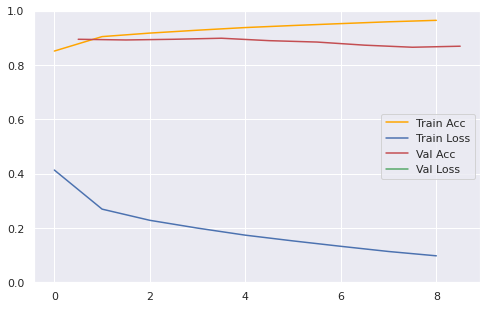

In [178]:
plot_history(history)

In [179]:
from tensorflow.keras.models import save_model, load_model
save_model(model,'2.model')

In [180]:
saved_model = load_model('2.model', compile=False)
saved_model.compile(optimizer='adam',
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])
predictions = saved_model.predict([X_test])

157/157 [==============================] - 3s 17ms/step


In [181]:
np.argmax(predictions[4600])

5

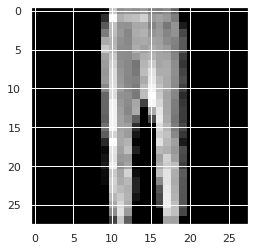

In [182]:
image = X_test[0]
fig = plt.figure
plt.imshow(image, cmap = 'gray')
plt.show()

In [183]:
score = model.evaluate(X_test, y_test, verbose=0)
print(type(score))
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

<class 'list'>
Test Score: 4.199514389038086
Test Accuracy: 0.10199999809265137


In [184]:
# Model 2 using new hidden sizes in reverse
# Baseline with LR 0.001

n_train = 60000
n_valid = 784
hiddensizes = [96, 64, 32] 
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.Adam
# learning rate
learningrate = 0.0001
# size of batch and number of epochs
batch_size = 50
n_epochs = 10

def model_cnn(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", input_shape=[28, 28, 1]))
    model.add(keras.layers.MaxPooling2D(pool_size=2))

    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn)) 
        model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
        model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, strides=1, padding="same", activation=actfn))  
        model.add(keras.layers.Flatten())                          # unravel into a 1D vector
        model.add(keras.layers.Dense(10, activation = "softmax"))  # 10 classes for this dataset
        model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])   
    return model

In [185]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    if further_callbacks != []:
        callbacks = further_callbacks
    else:
        callbacks = [early_stopping_cb]
    model = model_cnn(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:], y_train[:n_train], epochs=n_epochs, callbacks = callbacks,
                        validation_data=(X_valid[:n_valid,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

In [186]:
# Function that tests the model above
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/10
1875/1875 [==============================] - 209s 110ms/step - loss: 0.6781 - accuracy: 0.7597 - val_loss: 55.4699 - val_accuracy: 0.8099
Epoch 2/10
1875/1875 [==============================] - 206s 110ms/step - loss: 0.4362 - accuracy: 0.8443 - val_loss: 43.7515 - val_accuracy: 0.8418
Epoch 3/10
1875/1875 [==============================] - 208s 111ms/step - loss: 0.3845 - accuracy: 0.8626 - val_loss: 42.2754 - val_accuracy: 0.8571
Epoch 4/10
1875/1875 [==============================] - 209s 112ms/step - loss: 0.3538 - accuracy: 0.8741 - val_loss: 51.7203 - val_accuracy: 0.8342
Epoch 5/10
1875/1875 [==============================] - 214s 114ms/step - loss: 0.3327 - accuracy: 0.8811 - val_loss: 41.3238 - val_accuracy: 0.8661
Epoch 6/10
1875/1875 [==============================] - 206s 110ms/step - loss: 0.3154 - accuracy: 0.8881 - val_loss: 42.9893 - val_accuracy: 0.8571
Epoch 7/10
1875/1875 [==============================] - 208s 111ms/step - loss: 0.3015 - accuracy: 0.8926 

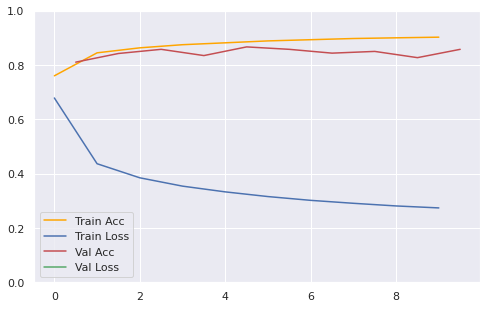

In [187]:
plot_history(history)

In [188]:
from tensorflow.keras.models import save_model, load_model
save_model(model,'21.model')

In [189]:
saved_model = load_model('21.model', compile=False)
saved_model.compile(optimizer='adam',
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])
predictions = saved_model.predict([X_test])

157/157 [==============================] - 4s 26ms/step


In [190]:
np.argmax(predictions[4600])

5

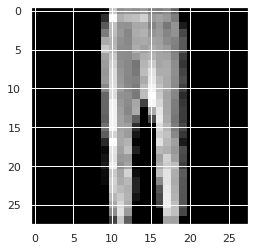

In [191]:
image = X_test[0]
fig = plt.figure
plt.imshow(image, cmap = 'gray')
plt.show()

In [192]:
score = model.evaluate(X_test, y_test, verbose=0)
print(type(score))
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

<class 'list'>
Test Score: 3.9636292457580566
Test Accuracy: 0.10199999809265137


###### Using SGD as optimiser

In [193]:
# Model 2 using new hidden sizes
# Baseline with LR 0.0001

n_train = 60000
n_valid = 784
hiddensizes = [32, 64, 96] 
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.SGD
# learning rate
learningrate = 0.0001
# size of batch and number of epochs
batch_size = 50
n_epochs = 20

def model_cnn(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", input_shape=[28, 28, 1]))
    model.add(keras.layers.MaxPooling2D(pool_size=2))

    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn)) 
        model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
        model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, strides=1, padding="same", activation=actfn))  
        model.add(keras.layers.Flatten())                          # unravel into a 1D vector
        model.add(keras.layers.Dense(10, activation = "softmax"))  # 10 classes for this dataset
        model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])   
    return model

In [194]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    if further_callbacks != []:
        callbacks = further_callbacks
    else:
        callbacks = [early_stopping_cb]
    model = model_cnn(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:], y_train[:n_train], epochs=n_epochs, callbacks = callbacks,
                        validation_data=(X_valid[:n_valid,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

In [195]:
# Function that tests the model above
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/20
1875/1875 [==============================] - 110s 58ms/step - loss: 2.2987 - accuracy: 0.1677 - val_loss: 21.4519 - val_accuracy: 0.1684
Epoch 2/20
1875/1875 [==============================] - 107s 57ms/step - loss: 2.2851 - accuracy: 0.1750 - val_loss: 20.3249 - val_accuracy: 0.1798
Epoch 3/20
1875/1875 [==============================] - 111s 59ms/step - loss: 2.2707 - accuracy: 0.1728 - val_loss: 19.8760 - val_accuracy: 0.1798
Epoch 4/20
1875/1875 [==============================] - 107s 57ms/step - loss: 2.2528 - accuracy: 0.1907 - val_loss: 19.6576 - val_accuracy: 0.1888
Epoch 5/20
1875/1875 [==============================] - 112s 60ms/step - loss: 2.2277 - accuracy: 0.2688 - val_loss: 19.8145 - val_accuracy: 0.2577
Epoch 6/20
1875/1875 [==============================] - 109s 58ms/step - loss: 2.1888 - accuracy: 0.3403 - val_loss: 20.3108 - val_accuracy: 0.3151
Epoch 7/20
 111/1875 [>.............................] - ETA: 1:42 - loss: 2.1608 - accuracy: 0.3818

KeyboardInterrupt: ignored

In [ ]:
plot_history(history)

In [ ]:
from tensorflow.keras.models import save_model, load_model
save_model(model,'23.model')


In [ ]:
saved_model = load_model('23.model', compile=False)
saved_model.compile(optimizer='adam',
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])
predictions = saved_model.predict([X_test])

In [ ]:
np.argmax(predictions[4600])

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print(type(score))
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

In [196]:
# Model 2 using new hidden sizes
# Baseline with LR 0.001

n_train = 60000
n_valid = 784
hiddensizes = [32, 64, 96] 
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.SGD
# learning rate
learningrate = 0.001
# size of batch and number of epochs
batch_size = 50
n_epochs = 20

def model_cnn(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", input_shape=[28, 28, 1]))
    model.add(keras.layers.MaxPooling2D(pool_size=2))

    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn)) 
        model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
        model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, strides=1, padding="same", activation=actfn))  
        model.add(keras.layers.Flatten())                          # unravel into a 1D vector
        model.add(keras.layers.Dense(10, activation = "softmax"))  # 10 classes for this dataset
        model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])   
    return model

In [197]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    if further_callbacks != []:
        callbacks = further_callbacks
    else:
        callbacks = [early_stopping_cb]
    model = model_cnn(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:], y_train[:n_train], epochs=n_epochs, callbacks = callbacks,
                        validation_data=(X_valid[:n_valid,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

In [198]:
# Function that tests the model above
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/20
 756/1875 [===========>..................] - ETA: 1:12 - loss: 2.2650 - accuracy: 0.1677

KeyboardInterrupt: ignored

In [ ]:
plot_history(history)

In [ ]:
from tensorflow.keras.models import save_model, load_model
save_model(model,'24.model')


In [ ]:
saved_model = load_model('24.model', compile=False)
saved_model.compile(optimizer='adam',
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])
predictions = saved_model.predict([X_test])

In [ ]:
np.argmax(predictions[4600])

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print(type(score))
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

###### DNN testing with Adam

In [199]:
# DNN Model 6
# Original DNN with increased hidden layer sizes

n_train = 60000
n_valid = 784
# number and size of hidden layers
hiddensizes = [32, 64, 96] 
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.Adam
learningrate = 0.0001 
# size of batch and number of epochs
batch_size = 50
n_epochs = 20

# and the function
def model_dense(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28, 28, 1])) 
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = actfn))
    model.add(keras.layers.Dense(25, activation = "softmax")) 
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])
    return model

In [200]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    if further_callbacks != []:
        callbacks = further_callbacks
    else:
        callbacks = [early_stopping_cb]
    model = model_dense(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:], y_train[:n_train], epochs=n_epochs, callbacks = callbacks,
                        validation_data=(X_valid[:n_valid,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

In [201]:
# Function that tests the model above
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/20
1875/1875 [==============================] - 9s 4ms/step - loss: 0.8820 - accuracy: 0.7109 - val_loss: 72.9270 - val_accuracy: 0.7857
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5110 - accuracy: 0.8222 - val_loss: 72.7999 - val_accuracy: 0.8023
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4550 - accuracy: 0.8404 - val_loss: 70.9937 - val_accuracy: 0.8214
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4277 - accuracy: 0.8492 - val_loss: 66.4133 - val_accuracy: 0.8393
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4085 - accuracy: 0.8557 - val_loss: 67.5202 - val_accuracy: 0.8329
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3943 - accuracy: 0.8609 - val_loss: 68.3111 - val_accuracy: 0.8329
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3837 - accuracy: 0.8635 - val_loss: 56.8729 - val_ac

In [202]:
from tensorflow.keras.models import save_model, load_model
save_model(model,'600.model')

In [203]:
# DNN Model 6
# Original DNN with increased hidden layer sizes

n_train = 60000
n_valid = 784
# number and size of hidden layers
hiddensizes = [32, 64, 96] 
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.Adam
learningrate = 0.001 
# size of batch and number of epochs
batch_size = 50
n_epochs = 20

# and the function
def model_dense(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28, 28, 1])) 
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = actfn))
    model.add(keras.layers.Dense(25, activation = "softmax")) 
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])
    return model

In [204]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    if further_callbacks != []:
        callbacks = further_callbacks
    else:
        callbacks = [early_stopping_cb]
    model = model_dense(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:], y_train[:n_train], epochs=n_epochs, callbacks = callbacks,
                        validation_data=(X_valid[:n_valid,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

In [205]:
# Function that tests the model above
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5452 - accuracy: 0.8081 - val_loss: 50.5241 - val_accuracy: 0.8380
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3900 - accuracy: 0.8589 - val_loss: 50.0739 - val_accuracy: 0.8546
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3584 - accuracy: 0.8694 - val_loss: 45.9298 - val_accuracy: 0.8635
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3375 - accuracy: 0.8751 - val_loss: 85.1777 - val_accuracy: 0.7985
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3244 - accuracy: 0.8804 - val_loss: 60.2348 - val_accuracy: 0.8202
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3112 - accuracy: 0.8857 - val_loss: 48.4500 - val_accuracy: 0.8520
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3017 - accuracy: 0.8899 - val_loss: 69.2807 - val_ac

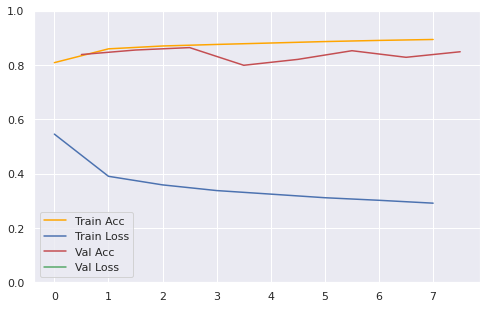

In [206]:
plot_history(history)

In [207]:
from tensorflow.keras.models import save_model, load_model
save_model(model,'60.model')

In [208]:
saved_model = load_model('6.model', compile=False)
saved_model.compile(optimizer='adam',
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])
predictions = saved_model.predict([X_test])

157/157 [==============================] - 0s 2ms/step


In [209]:
np.argmax(predictions[4600])

5

In [210]:
score = model.evaluate(X_test, y_test, verbose=0)
print(type(score))
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

<class 'list'>
Test Score: 4.080015182495117
Test Accuracy: 0.10199999809265137


###### DNN with SGD

In [211]:
# DNN Model 6
# Original DNN with increased hidden layer sizes

n_train = 60000
n_valid = 784
# number and size of hidden layers
hiddensizes = [32, 64, 96] 
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.SGD
learningrate = 0.0001 
# size of batch and number of epochs
batch_size = 50
n_epochs = 20

# and the function
def model_dense(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28, 28, 1])) 
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = actfn))
    model.add(keras.layers.Dense(25, activation = "softmax")) 
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])
    return model

In [212]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    if further_callbacks != []:
        callbacks = further_callbacks
    else:
        callbacks = [early_stopping_cb]
    model = model_dense(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:], y_train[:n_train], epochs=n_epochs, callbacks = callbacks,
                        validation_data=(X_valid[:n_valid,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

In [213]:
# Function that tests the model above
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/20
1875/1875 [==============================] - 5s 2ms/step - loss: 3.1949 - accuracy: 0.0555 - val_loss: 90.2411 - val_accuracy: 0.0918
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 3.0088 - accuracy: 0.0900 - val_loss: 103.5868 - val_accuracy: 0.0906
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 2.7902 - accuracy: 0.0994 - val_loss: 94.5259 - val_accuracy: 0.1046
Epoch 4/20
1875/1875 [==============================] - 5s 2ms/step - loss: 2.5182 - accuracy: 0.1468 - val_loss: 46.5684 - val_accuracy: 0.1990
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 2.2690 - accuracy: 0.3135 - val_loss: 37.7217 - val_accuracy: 0.3367
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 2.0728 - accuracy: 0.3948 - val_loss: 36.5652 - val_accuracy: 0.4018
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.9052 - accuracy: 0.4516 - val_loss: 32.9995 - val_a

In [214]:
from tensorflow.keras.models import save_model, load_model
save_model(model,'611.model')


In [215]:
# DNN Model 6
# Original DNN with increased hidden layer sizes

n_train = 60000
n_valid = 784
# number and size of hidden layers
hiddensizes = [32, 64, 96] 
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.SGD
learningrate = 0.001 
# size of batch and number of epochs
batch_size = 50
n_epochs = 20

# and the function
def model_dense(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28, 28, 1])) 
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = actfn))
    model.add(keras.layers.Dense(25, activation = "softmax")) 
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])
    return model

In [216]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    if further_callbacks != []:
        callbacks = further_callbacks
    else:
        callbacks = [early_stopping_cb]
    model = model_dense(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:], y_train[:n_train], epochs=n_epochs, callbacks = callbacks,
                        validation_data=(X_valid[:n_valid,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

In [217]:
# Function that tests the model above
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/20
1875/1875 [==============================] - 5s 2ms/step - loss: 2.2439 - accuracy: 0.3419 - val_loss: 46.6494 - val_accuracy: 0.5727
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.0883 - accuracy: 0.6178 - val_loss: 63.9563 - val_accuracy: 0.6365
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.8811 - accuracy: 0.6768 - val_loss: 70.8298 - val_accuracy: 0.6888
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7839 - accuracy: 0.7169 - val_loss: 75.9876 - val_accuracy: 0.7156
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7187 - accuracy: 0.7450 - val_loss: 71.4503 - val_accuracy: 0.7258
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6686 - accuracy: 0.7639 - val_loss: 75.5049 - val_accuracy: 0.7347
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6296 - accuracy: 0.7770 - val_loss: 77.9916 - val_ac

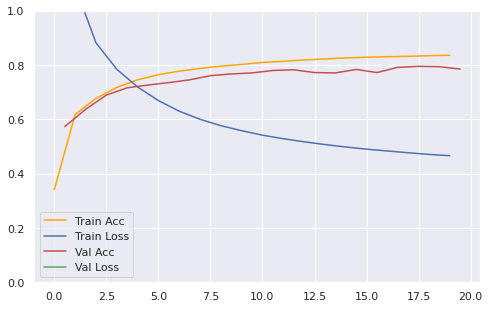

In [218]:
plot_history(history)

In [219]:
from tensorflow.keras.models import save_model, load_model
save_model(model,'61.model')


In [220]:
saved_model = load_model('61.model', compile=False)
saved_model.compile(optimizer='adam',
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])
predictions = saved_model.predict([X_test])

157/157 [==============================] - 0s 2ms/step


In [221]:
np.argmax(predictions[4600])

5

In [222]:
score = model.evaluate(X_test, y_test, verbose=0)
print(type(score))
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

<class 'list'>
Test Score: 3.0443813800811768
Test Accuracy: 0.10199999809265137


In [223]:
# DNN Model 6
# Original DNN with increased hidden layer sizes

n_train = 60000
n_valid = 784
# number and size of hidden layers
hiddensizes = [32, 64, 96] 
# activation function to be used by hidden layers
actfn = "relu"
# optimiser and learning rate
optimizer = keras.optimizers.SGD
learningrate = 0.0001 
# size of batch and number of epochs
batch_size = 50
n_epochs = 20

# and the function
def model_dense(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28, 28, 1])) 
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = actfn))
    model.add(keras.layers.Dense(25, activation = "softmax")) 
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])
    return model

In [224]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    if further_callbacks != []:
        callbacks = further_callbacks
    else:
        callbacks = [early_stopping_cb]
    model = model_dense(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:], y_train[:n_train], epochs=n_epochs, callbacks = callbacks,
                        validation_data=(X_valid[:n_valid,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

In [225]:
# Function that tests the model above
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/20
1875/1875 [==============================] - 5s 2ms/step - loss: 3.1568 - accuracy: 0.0741 - val_loss: 70.0522 - val_accuracy: 0.1186
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 2.9506 - accuracy: 0.1605 - val_loss: 84.4899 - val_accuracy: 0.1620
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 2.6825 - accuracy: 0.1957 - val_loss: 94.7772 - val_accuracy: 0.2245
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 2.3996 - accuracy: 0.2646 - val_loss: 75.3571 - val_accuracy: 0.2717
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 2.1760 - accuracy: 0.3358 - val_loss: 55.0887 - val_accuracy: 0.3967
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 2.0062 - accuracy: 0.4436 - val_loss: 52.0627 - val_accuracy: 0.4579
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.8564 - accuracy: 0.4942 - val_loss: 52.3482 - val_ac

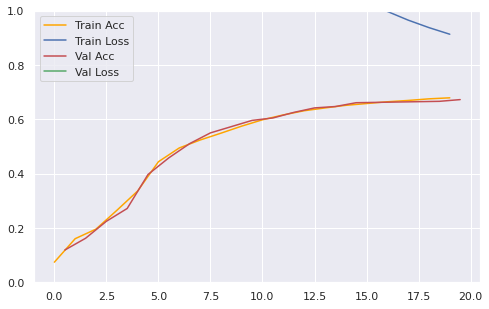

In [226]:
plot_history(history)

In [227]:
from tensorflow.keras.models import save_model, load_model
save_model(model,'611.model')


In [228]:
saved_model = load_model('611.model', compile=False)
saved_model.compile(optimizer='adam',
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])
predictions = saved_model.predict([X_test])

157/157 [==============================] - 0s 2ms/step


In [229]:
np.argmax(predictions[4600])

5

In [230]:
score = model.evaluate(X_test, y_test, verbose=0)
print(type(score))
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

<class 'list'>
Test Score: 3.0334854125976562
Test Accuracy: 0.10199999809265137
